In [1]:
import os,sys
import json
import geoplot
import pyproj
import json
import requests
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd

from functools import partial
from shapely.ops import transform
from io import StringIO
from shapely.geometry import Point, Polygon, mapping

%matplotlib inline

In [656]:
!cd

C:\Users\Timo\AnacondaProjects\work\wmo-notebooks


In [659]:
datadir = r"./data/"

if not os.path.isdir(datadir):
    print("warning..data not in place.. install large file system git")
    sys.exit(1)


# Load WMO Member information 
The boundaries, regional info and membership info are all included in the shapefile 

In [671]:
world_shapefile = os.path.join( datadir , "WMO/WMO-shapefile-BCT-ex.shp" )

gdf_world = gpd.read_file( world_shapefile )
gdf_world.crs = "epsg:4326"

print(gdf_world.shape)
gdf_world.head(1)

(214, 12)


,STATUS,TERR_NAME,POL_C_CODE,ABBREV,SHORT_NAME,ISO_2_CODE,LABELRANK,ISO_CODE_N,wmo_region,regional_i,wmo_member,geometry
0,WMO Member,Anguilla,AIA,B.C.T,Anguilla,AI,2.0,660.0,IV,IV,None,"POLYGON ((-63.15375 18.16528, -63.16778 18.164..."


## load geodata and world bank data for surface area 
We combine information from the World Bank (surface eare), marineregions.org (EEZs and inland lakes)
We also process data, e.g to add Greenland to Denmark and complete missing data (e.g Sudan)

In [672]:
# EEZs 
gdf_eez = gpd.read_file("zip://"+os.path.join( datadir , 'EEZ/eez_v10.zip')  ).set_index("ISO_Ter1")
gdf_eez.crs = "epsg:4326"

gdf_eez=gdf_eez[gdf_eez["Pol_type"]=='200NM'] # remove disputed

df_eez = gdf_eez.reset_index().groupby('ISO_Ter1')["Area_km2"].sum().to_frame()
df_eez.columns = ['eez_area_km2']
df_eez.loc['DNK','eez_area_km2'] += df_eez.loc['GRL','eez_area_km2'] #add Greenland to Denmark

gdf_world=gdf_world.join(df_eez,on="POL_C_CODE") # add EEZ to our dataframe

# inland waters
gdf_inland_water = gpd.read_file("zip://"+os.path.join( datadir , 'EEZ/eez_internal_waters_v2.zip') ).set_index("ISO_Ter1")

df_int_water = gdf_inland_water.groupby('ISO_Ter1')["Area_km2"].sum().to_frame()
df_int_water.columns = ['int_water_km2']
df_int_water.loc['DNK','int_water_km2'] += df_int_water.loc['GRL','int_water_km2'] # add Greenland to Denmark

gdf_world=gdf_world.join(df_int_water,on="POL_C_CODE") # add inland water to our dataframe

# read surface area from World Bank data
df_surface_area = pd.read_csv( os.path.join( datadir ,  'WB\API_AG.LND.TOTL.K2_DS2_en_csv_v2_10578310.csv'),skiprows=4).set_index("Country Code")
df_surface_area.loc['DNK','2017'] += df_surface_area.loc['GRL','2017'] # combine Denmark and Greenland
df_surface_area = df_surface_area[["Country Name","2017"]].rename(columns={"2017":"surface_area_km2_wb"})

# add computed and World Bank land area size and create totals
gdf_world_area=gdf_world.join((gdf_world.to_crs("+proj=eqearth").area/10**6).to_frame().rename(columns={0:"surface_area_km2_comp"}))
gdf_world_area=gdf_world_area.join(df_surface_area,on="POL_C_CODE")

# no WB data for South Sudan and Sudan.. use GIS calculated values 
sdn_idx = gdf_world_area.POL_C_CODE.isin(["SDN","SSD"])
gdf_world_area.loc[sdn_idx,"surface_area_km2_wb"] = gdf_world_area.loc[sdn_idx,"surface_area_km2_comp"]

gdf_world_area["surface_area_total_km2"] = gdf_world_area[["surface_area_km2_wb","eez_area_km2","int_water_km2"]].sum(axis=1) 
#gdf_world_area=gdf_world_area[["STATUS","TERR_NAME","POL_C_CODE","geometry","Numeric","surface_area_km2_comp","surface_area_km2_wb","surface_area_total_km2","eez_area_km2","int_water_km2"]]
gdf_world_area=gdf_world_area.set_index("POL_C_CODE")

# add numeric iso code to EEZ GDF
gdf_eez=gdf_eez.join(gdf_world_area[["ISO_CODE_N",]],how="inner")

gdf_world_area.head(2)

# TODO.. do we need to integrate futher areas, 
# US: Marshall Islands, Puerto Rico
# Netherlands: Sint Maarten
# Curacao 


,STATUS,TERR_NAME,ABBREV,SHORT_NAME,ISO_2_CODE,LABELRANK,ISO_CODE_N,wmo_region,regional_i,wmo_member,geometry,eez_area_km2,int_water_km2,surface_area_km2_comp,Country Name,surface_area_km2_wb,surface_area_total_km2
POL_C_CODE,,,,,,,,,,,,,,,,,
AIA,WMO Member,Anguilla,B.C.T,Anguilla,AI,2.0,660.0,IV,IV,None,"POLYGON ((-63.15375 18.16528, -63.16778 18.164...",90426.0,NaN,91.276776,NaN,NaN,90426.0
MSR,WMO Member,Montserrat,B.C.T,Montserrat,MS,2.0,500.0,IV,IV,None,"POLYGON ((-62.16556 16.67166, -62.17139 16.671...",7213.0,NaN,112.560281,NaN,NaN,7213.0


## station data from WDQMS

In [662]:
files = ["synop_ecmwf_2020_01_01-09.csv.gz","synop_ecmwf_2020_01_10-19.csv.gz","synop_ecmwf_2020_01_20-29.csv.gz","synop_ecmwf_2020_01_30-31.csv.gz"]
df_stations=None 
for f in files:
    f = os.path.join( datadir,  "WDQMS/{}".format(f))
    
    df = pd.read_csv(f)
    df=df[df.var_id==110]
    
    df_stations = pd.concat( [df_stations,df] )
    
df_stations.dropna(how="all",inplace = True) 

tmp = df_stations["name.1"].str.split("_",expand=True)
df_stations["center"] = tmp[1]
df_stations["datetime"] = pd.to_datetime( tmp[0] , format="%Y%m%d%H" )

df_stations.drop(columns=["name.1",],inplace=True)
df_stations.loc[df_stations.country_id=="ROM","country_id"] = "ROU" #incorrect country code for Roumania in WDQMS    
df_stations.loc[df_stations.country_id=="GRL","country_id"] = "DNK" #count Greenland stations towards Denmark    
    
    
geometry = [Point(xy) for xy in zip(df_stations.longitude , df_stations.latitude)]
crs =  'epsg:4326' 
gdf_stations = gpd.GeoDataFrame(df_stations[["wigosid","name","nr_received","nr_expected","datetime","country_id"]], crs=crs, geometry=geometry)

gdf_stations.head(5)

,wigosid,name,nr_received,nr_expected,datetime,country_id,geometry
11,0-20000-0-06687,QUINTEN,6,6,2020-01-06,CHE,POINT (9.21604 47.12874)
12,0-20000-0-06715,EVIONNAZ,6,6,2020-01-06,CHE,POINT (7.02676 46.18295)
13,0-20000-0-06782,DISENTIS,6,6,2020-01-06,CHE,POINT (8.85347 46.70657)
14,0-20000-0-06656,BRIENZ,6,6,2020-01-06,CHE,POINT (8.06086 46.74072)
15,0-20000-0-11201,SILLIAN,6,6,2020-01-06,AUT,POINT (12.42361 46.74639)


In [462]:
# baseline of stations. All unique stations
gdf_baseline=gdf_stations.drop_duplicates(subset="wigosid")

In [463]:
# stations that are reporting. At least 30% of expected reports on at least 60% of occasions 
per_exp = 0.3
per_occ = 0.6
GBON_per_6h = 6 # 1h observations


gdf_reporting=gdf_stations[gdf_stations.nr_received >= GBON_per_6h * per_exp ]
gdf_reporting=gpd.GeoDataFrame( gdf_reporting.groupby("wigosid").agg({"datetime":"count","geometry":"first","country_id":"first","name":"first"}).rename(columns={"datetime":"nr_ok_intervals"}))
gdf_reporting.crs = "epsg:4326"
gdf_reporting=gdf_reporting[gdf_reporting.nr_ok_intervals >= 31 * 4 * per_occ ]  #31 days of 4 intervals in Jan
print(gdf_reporting.shape)

per_exp = 0.8

gdf_reporting_2=gdf_stations[gdf_stations.nr_received >= GBON_per_6h * per_exp ]
gdf_reporting_2=gpd.GeoDataFrame( gdf_reporting_2.groupby("wigosid").agg({"datetime":"count","geometry":"first","country_id":"first","name":"first"}).rename(columns={"datetime":"nr_ok_intervals"}))
gdf_reporting_2.crs = "epsg:4326"
gdf_reporting_2=gdf_reporting_2[gdf_reporting_2.nr_ok_intervals >= 31 * 4 * per_occ ]  #31 days of 4 intervals in Jan
print(gdf_reporting_2.shape)


(7567, 4)
(2932, 4)


Text(0.5, 1.0, '2932 reporting stations (80% threshold)')

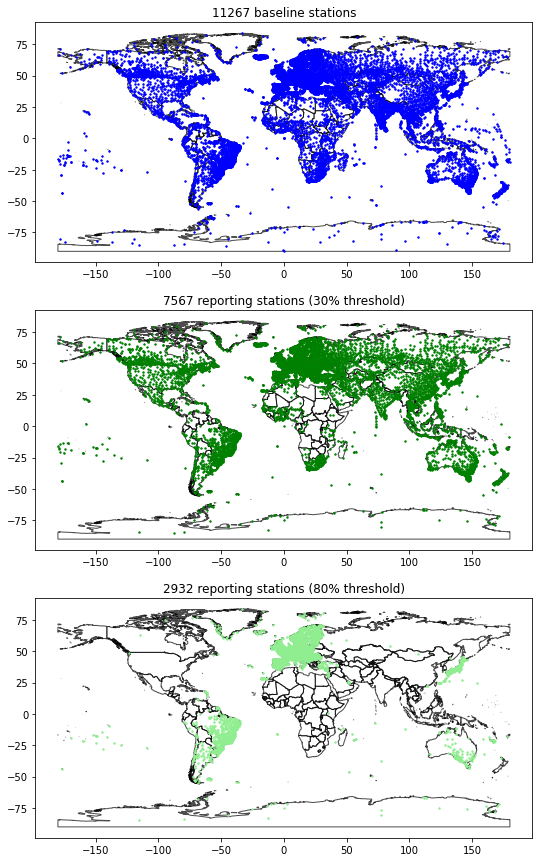

In [464]:
fig,(ax1,ax2,ax3) = plt.subplots(3,figsize=(15,15))

gdf_world.plot(ax=ax1,alpha=0.7,facecolor="none")
gdf_baseline.plot(ax=ax1,markersize=2,color="blue")
ax1.set_title("{} baseline stations".format(len(gdf_baseline)))

gdf_world.plot(ax=ax2,alpha=0.7,facecolor="none")
gdf_reporting.plot(ax=ax2,markersize=2,color="green")
ax2.set_title("{} reporting stations (30% threshold)".format(len(gdf_reporting)))

gdf_world.plot(ax=ax3,alpha=0.7,facecolor="none")
gdf_reporting_2.plot(ax=ax3,markersize=2,color="lightgreen")
ax3.set_title("{} reporting stations (80% threshold)".format(len(gdf_reporting_2)))


discarding CW
nr close home 1026
nr close EEZ 68
nr far EEZ 0


C:\Users\Timo\Anaconda3\envs\workenv\lib\site-packages\geopandas\plotting.py:510: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,


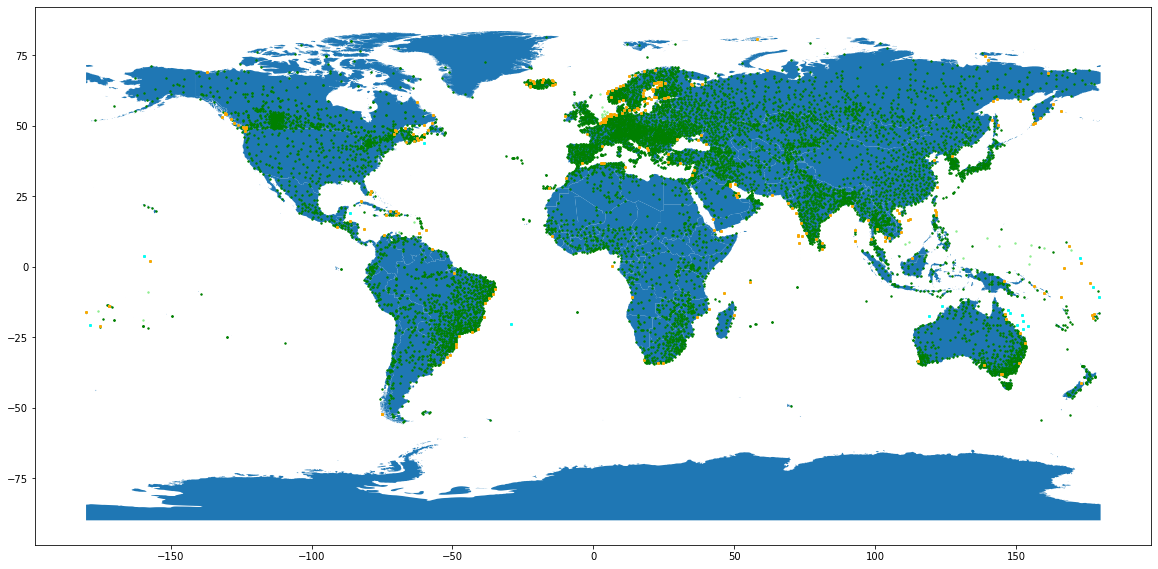

In [493]:
station_cols = ["wigosid","name","country_id","index_right","geometry"]
tmp = gpd.sjoin(gdf_baseline,gdf_world_area,op="within",how="left")[station_cols].rename(columns={"index_right":"ISO3_CODE"})
idx_stations_in_country = ~tmp.ISO3_CODE.isna() & ~(tmp.ISO3_CODE=="ATA")
stations_in_country = tmp[idx_stations_in_country].copy() # stations inside a country boundary

stations_outside_country =  tmp[~idx_stations_in_country] 
tmp = gpd.sjoin(stations_outside_country,gdf_eez,op="within",how="left")[ station_cols ].rename(columns={"index_right":"ISO3_CODE"}) 
idx_stations_in_eez = ~tmp.ISO3_CODE.isna() & ~(tmp.ISO3_CODE=="ATA")
stations_in_eez = tmp[idx_stations_in_eez].copy() # stations inside a country boundary

stations_outside_eez = tmp[idx_stations_in_eez]

# calculate distance to home country
stations_outside_eez_with_country = stations_outside_eez[~stations_outside_eez.country_id.isna()]

problem_stations = []
stations_close_to_home = []
stations_far_from_home = []
for i,o in stations_outside_eez_with_country.iterrows():
    if not o.country_id in gdf_world_area.index: #discard stations 
        print("discarding",o.country_id)
        continue
    try:
        d=o.geometry.distance(gdf_world_area.loc[[o.country_id,]].geometry[0])
        if d <= 1.0:
            stations_close_to_home.append(o)
        else:
            stations_far_from_home.append(o)
    except TypeError:
        problem_stations.append(o)

stations_close_to_home = gpd.GeoDataFrame(stations_close_to_home)
stations_far_from_home = gpd.GeoDataFrame(stations_far_from_home)

# calculate distance to home EEZ (we have excluded station without a home country_id already)
stations_close_to_eez = []
stations_far_from_eez = []
for i,o in stations_far_from_home.iterrows():
    try:
        d  = min([ o.geometry.distance( g ) for g in gdf_eez.loc[o.country_id].geometry ])
        if d <= 1.0:
            stations_close_to_eez.append(o)
        else:
            stations_far_from_eez.append(o)
    except TypeError:
        problem_stations.append(o)
stations_close_to_eez = gpd.GeoDataFrame(stations_close_to_eez)
stations_far_from_eez = gpd.GeoDataFrame(stations_far_from_eez)
        
# finally.. yellow stations outside the country borders and EEZ
#TODO

# consolidate COUNTRY ID
idx_no_country = stations_in_country.country_id.isna()
stations_in_country.loc[idx_no_country,"country_id"] = stations_in_country.loc[idx_no_country,"ISO3_CODE"]
stations_in_country.drop(["ISO3_CODE",],axis=1,inplace=True)

idx_no_country = stations_in_eez.country_id.isna()
stations_in_eez.loc[idx_no_country,"country_id"] = stations_in_eez.loc[idx_no_country,"ISO3_CODE"]
stations_in_eez.drop(["ISO3_CODE",],axis=1,inplace=True)

idx_no_country = stations_close_to_home.country_id.isna()
stations_close_to_home.loc[idx_no_country,"country_id"] = stations_close_to_home.loc[idx_no_country,"ISO3_CODE"]
stations_close_to_home.drop(["ISO3_CODE",],axis=1,inplace=True)

idx_no_country = stations_close_to_eez.country_id.isna()
stations_close_to_eez.loc[idx_no_country,"country_id"] = stations_close_to_eez.loc[idx_no_country,"ISO3_CODE"]
stations_close_to_eez.drop(["ISO3_CODE",],axis=1,inplace=True)

gdf_baseline = gpd.GeoDataFrame( pd.concat( [stations_in_country,stations_in_eez,stations_close_to_home,stations_close_to_eez], ignore_index=True) )
gdf_baseline.crs="epsg:4326"

print("nr close home",len(stations_close_to_home))
print("nr close EEZ",len(stations_close_to_eez))
print("nr far EEZ",len(stations_far_from_eez))

ax=gdf_world_area.plot(figsize=(20,20))
stations_in_country.plot(ax=ax,color="green",markersize=2)
stations_in_eez.plot(ax=ax,color="lightgreen",markersize=2)
stations_close_to_home.plot(ax=ax,color="orange",markersize=2)

stations_close_to_eez.plot(ax=ax,color="cyan",markersize=2)
stations_far_from_eez.plot(ax=ax,color="red",markersize=18)

In [494]:
def calculate_HR(gdf_stations,gdf_world,fieldname="HR"):
    gdf_world = gdf_world.copy()
    # compute crude country level HR ( land area / nr stations  )
    stations_by_country = gpd.sjoin(gdf_stations,gdf_world,op="within",how="inner").groupby("index_right").TERR_NAME.count()
    
    gdf_world = gdf_world.join(stations_by_country.rename("nr_stations_"+fieldname))
    gdf_world[fieldname] = np.sqrt(gdf_world.surface_area_total_km2) / np.sqrt(gdf_world["nr_stations_"+fieldname])
    
    return gdf_world
    
gdf_world_area_stations = calculate_HR(gdf_baseline,gdf_world_area,"HR_baseline")
gdf_world_area_stations = calculate_HR(gdf_reporting,gdf_world_area_stations,"HR_reporting_30")
gdf_world_area_stations = calculate_HR(gdf_reporting_2,gdf_world_area_stations,"HR_reporting_80")
gdf_world_area_stations.head()

,STATUS,TERR_NAME,ABBREV,SHORT_NAME,ISO_2_CODE,LABELRANK,ISO_CODE_N,wmo_region,regional_i,wmo_member,...,surface_area_km2_comp,Country Name,surface_area_km2_wb,surface_area_total_km2,nr_stations_HR_baseline,HR_baseline,nr_stations_HR_reporting_30,HR_reporting_30,nr_stations_HR_reporting_80,HR_reporting_80
AFG,WMO Member,Afghanistan,Afg.,Afghanistan,AF,2.0,4.0,II,II,1956-09-11,...,6.419079e+05,Afghanistan,652860.0,652860.0,12.0,233.248794,NaN,NaN,NaN,NaN
AGO,WMO Member,Angola,Ang.,Angola,AO,2.0,24.0,I,I,1977-03-16,...,1.247366e+06,Angola,1246700.0,1745798.0,17.0,320.459046,NaN,NaN,NaN,NaN
AIA,WMO Member,Anguilla,B.C.T,Anguilla,AI,2.0,660.0,IV,IV,None,...,9.127678e+01,NaN,NaN,90426.0,NaN,NaN,NaN,NaN,NaN,NaN
ALB,WMO Member,Albania,Alb.,Albania,AL,5.0,8.0,VI,VI,1957-07-29,...,2.865435e+04,Albania,27400.0,40244.0,9.0,66.869691,8.0,70.926018,1.0,200.609073
AND,WMO Member,Andorra,And.,Andorra,AD,5.0,20.0,VI,VI,-0001-11-30,...,5.071438e+02,Andorra,470.0,470.0,NaN,NaN,NaN,NaN,NaN,NaN


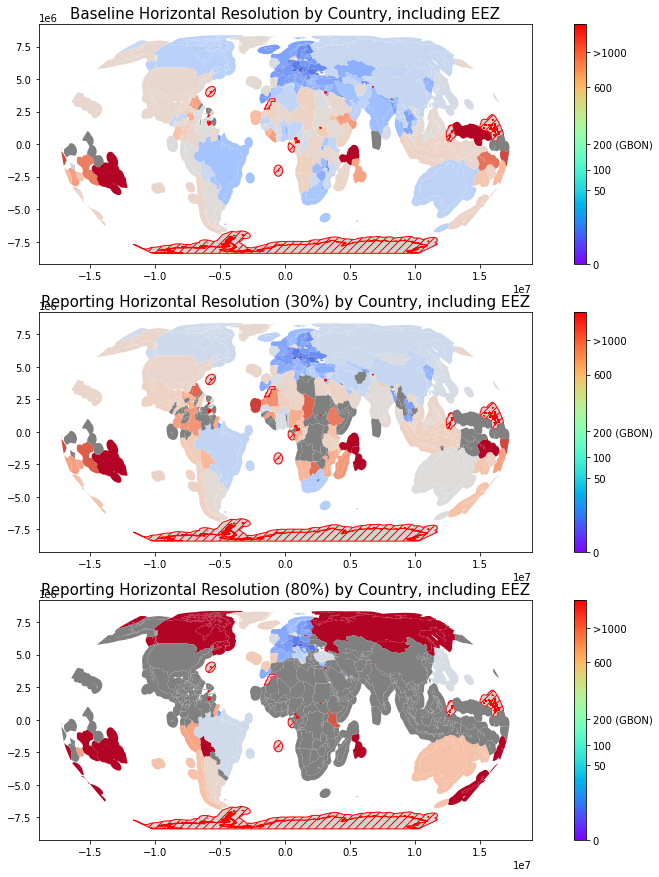

In [652]:
fig,(ax1,ax2,ax3) = plt.subplots(3,1,figsize=(15,15))

def plot_HR(df,column,title,ax):
    """Plots the HR indicated in `column` into the map passed in `df`.
    The EEZ of the country are also plotted in the same color.
    Non-WMO Member states are plotted in grey with red borders.
    WMO Members with zero HR are shown black
    """


    missing = {   "color": "lightgrey", "edgecolor": "red",
                   "hatch": "///", "label": "Missing values" }

    min_hr = df[column].min()
    max_hr = df[column].max()
    
    cmap="coolwarm"
    norm = TwoSlopeNorm(vmin=0, vcenter=200., vmax=1000)    


    idx_member = df.STATUS == "WMO Member"
    wmo_members = df[idx_member].index.values
    
    idx_missing = ( df[column].isna() & idx_member ) 
    
    df[idx_member].to_crs("+proj=eqearth").plot(column=column, legend=False, cmap=cmap, norm=norm, ax=ax )
    df[~df.index.isin(wmo_members)].to_crs("+proj=eqearth").plot(ax=ax, **missing) #plot non Members
    df[idx_missing].to_crs("+proj=eqearth").plot(facecolor="grey",ax=ax)

    #missing_kwds=missing


    
    # add EEZ
    gdf_eez_plus = gdf_eez.join(df[[column,]],how='inner')
    
    idx_member = gdf_eez_plus.index.isin(wmo_members)
    
    idx_missing = ( gdf_eez_plus[column].isna() & idx_member )
    
    gdf_eez_plus[idx_member].to_crs("+proj=eqearth").plot(column=column, legend=False, cmap=cmap, norm=norm, ax=ax)
    gdf_eez_plus[~idx_member].to_crs("+proj=eqearth").plot(ax=ax,**missing) #plot non Members EEZ
    gdf_eez_plus[idx_missing].to_crs("+proj=eqearth").plot(facecolor="grey",ax=ax)

    ax.set_title(title, fontsize=15)

    ticks=[0,50,100,200,600,1000]
    ax_cbar = fig.colorbar(cbar, ax=ax, ticks=ticks)
    #ax_cbar.set_label('Horizontal resolution in km^2')
    ax_cbar.ax.set_yticklabels(["0","50","100","200 (GBON)","600",">1000"])
    
plot_HR(gdf_world_area_stations,"HR_baseline","Baseline Horizontal Resolution by Country, including EEZ",ax1)
plot_HR(gdf_world_area_stations,"HR_reporting_30","Reporting Horizontal Resolution (30%) by Country, including EEZ",ax2)
plot_HR(gdf_world_area_stations,"HR_reporting_80","Reporting Horizontal Resolution (80%) by Country, including EEZ",ax3)
    
    
#plt.savefig(r'C:\TEMP\GBON-res.png')

# KDE with sklearn
using a more low level library we can better access crucial parameters 
I am using a different basemap for convenience here (can be changed later)


In [496]:
import json
import numpy as np
import matplotlib.pyplot as plt

from sklearn.neighbors import KernelDensity
from mpl_toolkits.basemap import Basemap


In [642]:
def construct_grids(data,width=0.05,borderspace=5):
    y_min = data[:,0].min() - borderspace
    y_max = data[:,0].max() + borderspace

    x_min = data[:,1].min() - borderspace
    x_max = data[:,1].max() + borderspace

    x_steps = (x_max-x_min) / width
    y_steps = (y_max-y_min) / width
    
    xgrid = np.linspace(x_min,x_max,x_steps)
    ygrid = np.linspace(y_min,y_max,y_steps)
    
    return [xgrid,ygrid]

def construct_global_grid(world,eez,width=0.05):
    x_min = -180
    x_max = 180
    
    y_min = -90
    y_max = 90
       
    x_steps = (x_max-x_min) / width
    y_steps = (y_max-y_min) / width
    
    xgrid = np.linspace(x_min,x_max,x_steps)
    ygrid = np.linspace(y_min,y_max,y_steps)
    
    X, Y = np.meshgrid(xgrid[::5], ygrid[::5][::-1])
    xy = np.vstack([Y.ravel(), X.ravel()]).T
   
    gdf_grid = gpd.GeoDataFrame( geometry=gpd.points_from_xy( xy[:,1],xy[:,0] ) , crs="epsg:4326" )
   
    gdf_grid = gpd.sjoin(gdf_grid,world.reset_index(),op="within",how="left").drop(["index_right",],axis=1)
    gdf_grid = gdf_grid[~gdf_grid.index.duplicated(keep="first")] 

    tmp=gpd.sjoin(gdf_grid[gdf_grid.POL_C_CODE.isna()].drop(["POL_C_CODE",],axis=1) , eez.reset_index() ,op="within",how="left")
    tmp=tmp[~tmp.index.duplicated(keep="first")]

    gdf_grid.loc[tmp.index,"POL_C_CODE"] = tmp["index"]
    
    return xy,gdf_grid[["POL_C_CODE",]],X,Y

xy,gdf_grid,X,Y=construct_global_grid(gdf_world_area,gdf_eez)


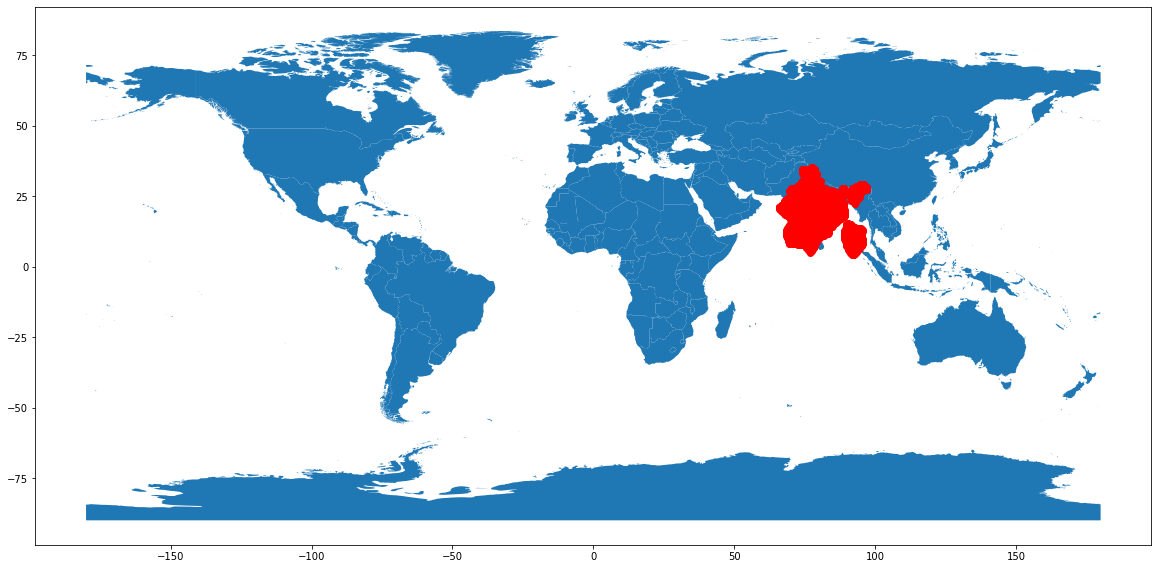

In [636]:
iso3="IND"
ax=gdf_world.plot(figsize=(20,20))
gpd.GeoDataFrame( geometry=gpd.points_from_xy( xy[gdf_grid.POL_C_CODE==iso3,1], xy[gdf_grid.POL_C_CODE==iso3,0] ) , crs="epsg:4326" ).plot(ax=ax,color="red")

len stations: 180, len grid: 1036800 len xy: 1036800


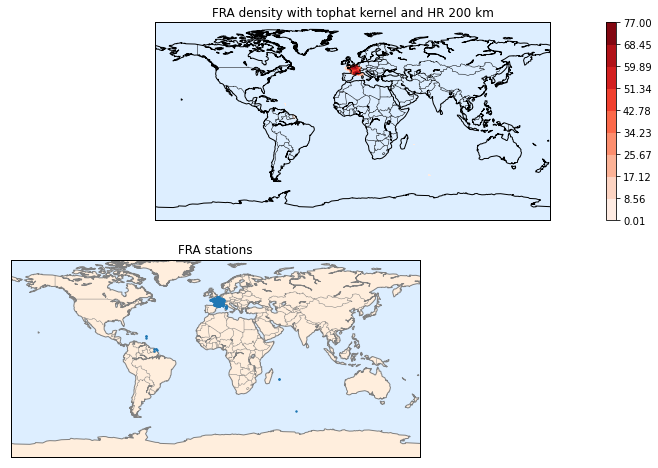

In [646]:
def compute_density(stations,grid,xy,X,Y,iso3,plot=True):
    
    stations=stations[stations.country_id==iso3]
    print("len stations: {}, len grid: {} len xy: {}".format(len(stations),len(grid),len(xy)))

    latlong=np.vstack([stations.geometry.y,stations.geometry.x]).T
    
    country_mask = grid.POL_C_CODE==iso3
    xy = np.radians(xy[country_mask] ) # apply land mask
    
    # distance as measured by haversine. Multiply by 6371000/1000 to get distaince in km
    HR = 200
    bandwidth = (HR)  / 6371 #  6371 being the radius of the earth

    cmap = 'Reds'

    if plot:
        fig,ax=plt.subplots(2,1,figsize=(20,8))
        # plot coastlines with basemap
        ax[0].set_title( "{} density with tophat kernel and HR {} km".format(iso3,HR))
        m = Basemap(projection='cyl', llcrnrlat=Y.min(),
                    urcrnrlat=Y.max(), llcrnrlon=X.min(),
                    urcrnrlon=X.max(), resolution='c', ax=ax[0])
        m.drawmapboundary(fill_color='#DDEEFF')
        m.drawcoastlines()
        m.drawcountries()

    # construct a spherical kernel density estimate of the distribution
    kde = KernelDensity(bandwidth=bandwidth, kernel="tophat" , metric='haversine')
    kde.fit(np.radians(latlong))
    #Z = kde.score_samples(xy)
    #Z = np.exp(kde.score_samples(xy))
    
    # evaluate only on the land: -9999 indicates ocean
    Z = np.full(country_mask.shape[0], -1)
    Z[country_mask] = np.exp(kde.score_samples(xy))
    Z = Z.reshape(X.shape)

    if plot:
        # plot contours of the density
        levels = np.linspace(0.01,Z.max(),10)

        cs3 = ax[0].contourf(X, Y, Z, levels=levels, cmap=cmap)
        #cs3 = ax[0].contourf(X, Y, Z,  cmap=cmap)

        fig.colorbar(cs3,ax=ax[0])

        # plot points for comparison
        m = Basemap(projection='cyl', resolution='c',
                    llcrnrlat=ygrid.min(), urcrnrlat=ygrid.max(),
                    llcrnrlon=xgrid.min(), urcrnrlon=xgrid.max(),ax=ax[1])
        m.drawmapboundary(fill_color='#DDEEFF')
        m.fillcontinents(color='#FFEEDD')
        m.drawcoastlines(color='gray', zorder=2)
        m.drawcountries(color='gray', zorder=2)

        # plot locations
        m.scatter(latlong[:, 1], latlong[:, 0], zorder=3, s=2,
                   cmap='rainbow', latlon=True);

        ax[1].set_title(iso3+" stations")
        
    return Z,country_mask 
    
    
#plt.savefig(r'C:\TEMP\GBON-KDE-tophat.png')
# def compute_density(stations,grid,xy,iso3,plot=True):
    
density,mask = compute_density(gdf_baseline,gdf_grid,xy,X,Y,"FRA")



In [ ]:
density = density.ravel()[mask]

In [525]:
std_nrml_den = (density / density.max()).std()
std_den = density.std()
mean_den = density.mean()
print("std {:0.2f} mean {:0.2f} normalized std {:0.2f}".format(std_den,mean_den,std_nrml_den))

std 19.81 mean 72.15 normalized std 0.17


Text(0.5, 1.0, 'RA-I stations')

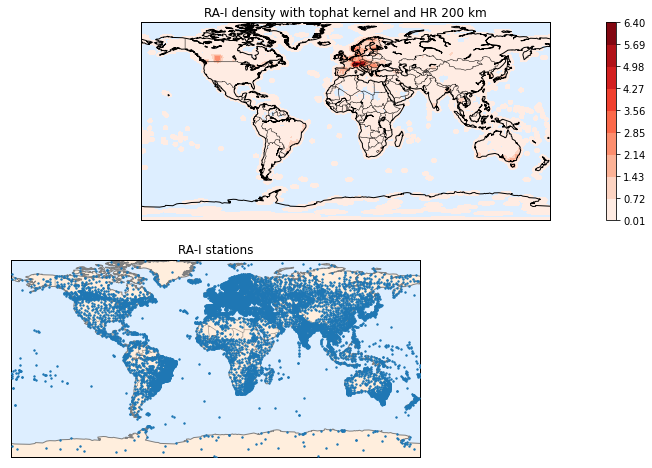

# colorbar testing 

[Text(1, 0, '0'),
 Text(1, 0, '200 GBON'),
 Text(1, 0, '600'),
 Text(1, 0, '1000'),
 Text(1, 0, '1400')]

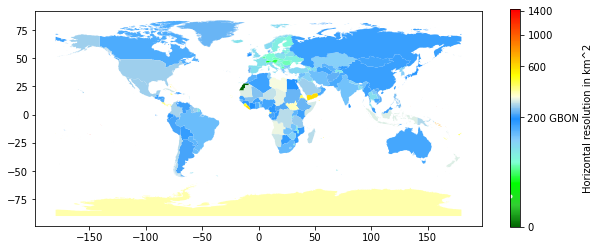

In [448]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, Normalize, PowerNorm, TwoSlopeNorm
import matplotlib as mpl
from pylab import *

x,y,c = zip(*np.random.rand(200,3)*2000-10)

#normalization of colors with Power law (gamma=1 is linear)

vmax=gdf_world_area_stations.HR_baseline.max()

#creating a linear segmented colormap from a list of colors
cmap = LinearSegmentedColormap.from_list("",[(0, 'darkgreen'), (0.1, 'limegreen'), (0.2, 'lime'), (0.3, 'aquamarine'), (0.4, 'lightskyblue'), (0.5, 'dodgerblue'), (0.6, 'lightyellow'), (0.7, 'yellow'), (0.8, 'orange'), (1, 'red')])

#creating a linear segmented colormap from a list of colors seperated into two different color areas
#cmap = cm.colors.LinearSegmentedColormap.from_list("",[(0, 'darkgreen'), (0.0305, 'limegreen'), (0.0512, 'lime'), (0.07, 'aquamarine'), (0.095, 'lightskyblue'), (0.153, 'dodgerblue'), (0.199, 'lightyellow'), (0.234, 'yellow'), (0.265, 'orange'), (0.305, 'red'), (0.305, 'white'), (0.4, 'thistle'), (0.5, 'orchid'), (0.6, 'wheat'), (0.7, 'honeydew'), (0.8, 'lightcyan'), (1, 'black')])

#norm = Normalize(vmin=gdf_world_area_stations.HR_baseline.min(), vmax=gdf_world_area_stations.HR_baseline.max())
norm = PowerNorm(gamma=0.35, vmin=gdf_world_area_stations.HR_baseline.min(), vmax=gdf_world_area_stations.HR_baseline.max())

cbar = plt.cm.ScalarMappable(norm=norm, cmap=cmap) # cmap='RdBu'

fig,ax=plt.subplots(1,figsize=(10,4))
gdf_world_area_stations[~gdf_world_area_stations.HR_baseline.isna()].plot(ax=ax,column="HR_baseline",
                                                                          legend=False,cmap=cmap,norm=norm)
ticks=[0,200,600,1000,1400]
ax_cbar = fig.colorbar(cbar, ax=ax, ticks=ticks)
ax_cbar.set_label('Horizontal resolution in km^2')

ax_cbar.ax.plot(0.1, 200, 'w.')

ax_cbar.ax.set_yticklabels([ ("{} GBON".format(t) if t==200 else t) for t in ticks ])

#plt.scatter(x,y,c=c, cmap=cmap, norm=norm)
#plt.colorbar()
#plt.show()

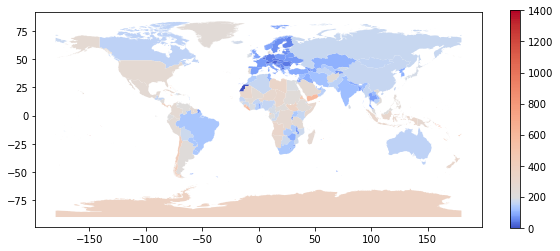

In [90]:
cmap="coolwarm"

norm = TwoSlopeNorm(vmin=0, vcenter=200., vmax=1400)

fig,ax=plt.subplots(1,figsize=(10,4))



gdf_world_area_stations[~gdf_world_area_stations.HR_baseline.isna()].plot(ax=ax,column="HR_baseline",
                                                                          legend=True,cmap=cmap, norm=norm)

In [73]:
gdf_world_area_stations[["TERR_NAME","HR_baseline"]].sort_values("HR_baseline",ascending=False)

,TERR_NAME,HR_baseline
MHL,Marshall Islands,1421.640602
PYF,French Polynesia,1264.208712
FSM,"Micronesia, Federated States of",1229.670891
SYC,Seychelles,1160.909557
TUV,Tuvalu,869.679826
PLW,Palau,820.320059
SLB,Solomon Islands,739.330553
COK,Cook Islands,702.932963
YEM,Yemen,593.678926
LBR,Liberia,590.943314


[Text(1, 0, '0'),
 Text(1, 0, '200 GBON'),
 Text(1, 0, '600'),
 Text(1, 0, '1000'),
 Text(1, 0, '1400')]

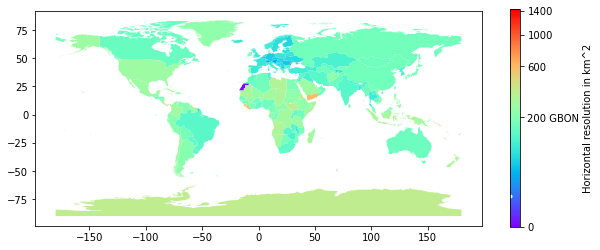

In [451]:
x,y,c = zip(*np.random.rand(200,3)*2000-10)

#normalization of colors with Power law (gamma=1 is linear)

vmax=gdf_world_area_stations.HR_baseline.max()

#creating a linear segmented colormap from a list of colors
cmap = LinearSegmentedColormap.from_list("",[(0, 'darkgreen'), (0.1, 'limegreen'), (0.2, 'lime'), (0.3, 'aquamarine'), (0.4, 'lightskyblue'), (0.5, 'dodgerblue'), (0.6, 'lightyellow'), (0.7, 'yellow'), (0.8, 'orange'), (1, 'red')])
cmap = "coolwarm"

#creating a linear segmented colormap from a list of colors seperated into two different color areas
#cmap = cm.colors.LinearSegmentedColormap.from_list("",[(0, 'darkgreen'), (0.0305, 'limegreen'), (0.0512, 'lime'), (0.07, 'aquamarine'), (0.095, 'lightskyblue'), (0.153, 'dodgerblue'), (0.199, 'lightyellow'), (0.234, 'yellow'), (0.265, 'orange'), (0.305, 'red'), (0.305, 'white'), (0.4, 'thistle'), (0.5, 'orchid'), (0.6, 'wheat'), (0.7, 'honeydew'), (0.8, 'lightcyan'), (1, 'black')])

#norm = Normalize(vmin=gdf_world_area_stations.HR_baseline.min(), vmax=gdf_world_area_stations.HR_baseline.max())
norm = PowerNorm(gamma=0.35, vmin=gdf_world_area_stations.HR_baseline.min(), vmax=gdf_world_area_stations.HR_baseline.max())

cbar = plt.cm.ScalarMappable(norm=norm, cmap=cmap) # cmap='RdBu'

fig,(ax1,ax2)=plt.subplots(2,figsize=(10,4))
gdf_world_area_stations[~gdf_world_area_stations.HR_baseline.isna()].plot(ax=ax,column="HR_baseline",
                                                                          legend=False,cmap=cmap,norm=norm)
ticks=[0,200,600,1000,1400]
ax_cbar = fig.colorbar(cbar, ax=ax, ticks=ticks)
ax_cbar.set_label('Horizontal resolution in km^2')

ax_cbar.ax.plot(0.1, 200, 'w.')

ax_cbar.ax.set_yticklabels([ ("{} GBON".format(t) if t==200 else t) for t in ticks ])

#plt.scatter(x,y,c=c, cmap=cmap, norm=norm)
#plt.colorbar()
#plt.show()